In [2]:
import os
import torch

from utils.dataloader import get_dataloaders
from utils.train import train_model, test_model

from utils.metrics import (
    compute_full_metrics,
    save_results_csv,
    plot_confusion_matrix,
    plot_roc_auc,
    save_grayscale_samples,
    save_epoch_history_excel
)

from models.hybrid_models import get_multi_hybrid_model,get_hybrid_model
from utils.gradCam1 import GradCAM,  show_gradcam, overlay_cam_on_image
import gc
import cv2
import numpy as np

# Config

In [ ]:
DATA_DIR = "lung_ct_split"
SEG_DATA_DIR = "lung_ct_lung_only"
BATCH_SIZE = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCH_OPTIONS = [5]

MODELS = {
    # "resnet50_vit": lambda: get_hybrid_model("resnet50"),
    # "efficientnet_vit": lambda: get_hybrid_model("efficientnet_b0"),
    "resnet50_densenet121_efficientnet_b4": lambda: get_multi_hybrid_model(
        cnn_list=("resnet50", "densenet121", "efficientnet_b4")
    ),
}

PREPROCESSING_CONFIGS = {

    # ---------------- BASELINE ----------------
    "baseline": {},

    # ---------------- WINDOWING ONLY ----------------
    "windowing": {
        "windowing": True,
    },

    # # # ---------------- CONTRAST ENHANCEMENT ----------------
    "clahe": {
        "clahe": True,
    },

    "hist_eq": {
        "hist_eq": True,
    },

    "window_clahe": {
        "windowing": True,
        "clahe": True,
    },

    # # ---------------- NOISE REMOVAL ----------------
    "gaussian": {
        "gaussian": True,
    },

    "median": {
        "median": True,
    },

    "clahe_median": {
        "clahe": True,
        "median": True,
    },

    "window_clahe_median": {
        "windowing": True,
        "clahe": True,
        "median": True,
    },

    # # ---------------- SHARPENING ----------------
    "sharpen": {
        "sharpen_flag": True,
    },

    "clahe_sharpen": {
        "clahe": True,
        "sharpen_flag": True,
    },

    # ---------------- NORMALIZATION ----------------
    "zscore": {
        "norm_type": "zscore",
    },

    "clahe_zscore": {
        "clahe": True,
        "norm_type": "zscore",
    },

    "window_clahe_zscore": {
        "windowing": True,
        "clahe": True,
        "norm_type": "zscore",
    },

    # ---------------- FULL MEDICAL PIPELINE ⭐ ----------------
    "full_medical_pipeline": {
        "windowing": True,
        "clahe": True,
        "median": True,
        "sharpen_flag": True,
        "norm_type": "zscore",
    },

    # ---------------- ALTERNATE FULL PIPELINE ----------------
    "full_gaussian_pipeline": {
        "windowing": True,
        "clahe": True,
        "gaussian": True,
        "sharpen_flag": True,
        "norm_type": "zscore",
    },
}



CSV_PATH = "results/reports/final_results.csv"

In [7]:
os.makedirs("results/roc_auc", exist_ok=True)
os.makedirs("results/confusion", exist_ok=True)
os.makedirs("results/grayscale", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Free up GPU memory

In [5]:
del model
del train_loader, val_loader, test_loader
torch.cuda.empty_cache()
gc.collect()

11323



 RUNNING EXPERIMENT: resnet50_densenet121_efficientnet_b4_clahe_median_ep5 

Epoch 1/5
Train Loss: 0.7073 | Train Acc: 0.7353
Val   Loss: 0.4642 | Val   Acc: 0.7805
Best model saved -> Epoch 1

Epoch 2/5
Train Loss: 0.4547 | Train Acc: 0.8540
Val   Loss: 0.3373 | Val   Acc: 0.9024
Best model saved -> Epoch 2

Epoch 3/5
Train Loss: 0.3312 | Train Acc: 0.9035
Val   Loss: 0.2231 | Val   Acc: 0.9268
Best model saved -> Epoch 3

Epoch 4/5
Train Loss: 0.2898 | Train Acc: 0.9153
Val   Loss: 0.2286 | Val   Acc: 0.9085

Epoch 5/5
Train Loss: 0.2385 | Train Acc: 0.9283
Val   Loss: 0.2256 | Val   Acc: 0.9207

 Best Epoch: 3 | Val Acc: 0.9268

resnet50_densenet121_efficientnet_b4 Test Accuracy: 0.9639
                 precision    recall  f1-score   support

   Bengin cases       0.88      0.78      0.82        18
Malignant cases       1.00      1.00      1.00        85
   Normal cases       0.94      0.97      0.95        63

       accuracy                           0.96       166
      macro 

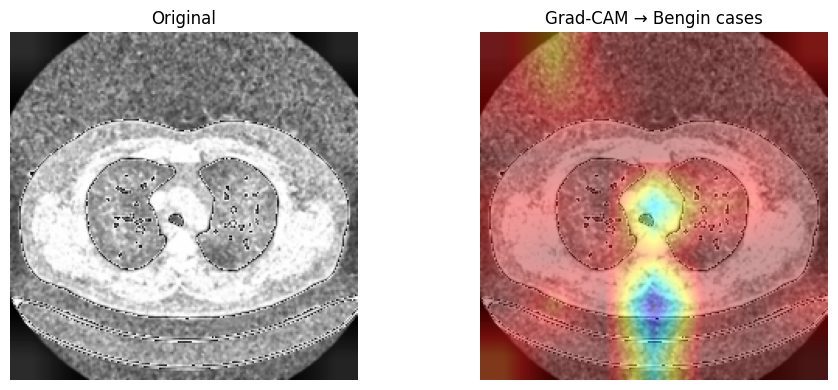



🏁 ALL EXPERIMENTS COMPLETED SUCCESSFULLY


In [8]:
for epochs in EPOCH_OPTIONS:
    for name, builder in MODELS.items():
        for prep_name, preprocess_cfg in PREPROCESSING_CONFIGS.items():

            exp_id = f"{name}_{prep_name}_ep{epochs}"
            print(f"\n\n RUNNING EXPERIMENT: {exp_id} ")

            train_loader, val_loader, test_loader, class_names = get_dataloaders(
                data_dir=DATA_DIR,
                batch_size=BATCH_SIZE,
                preprocess_config=preprocess_cfg,
            )

            model = builder().to(DEVICE)

            # -------- TRAIN --------
            model, history, summary = train_model(
                model,
                train_loader,
                val_loader,
                device=DEVICE,
                epochs=epochs,
                model_name=exp_id,
            )

            # save_epoch_history_excel(history, model_name=exp_id,save_path=f"results/{exp_id}/expriment_logs.xlsx")

            # -------- TEST --------
            test_acc, report, cm, labels, preds, probs, images = test_model(
                model,
                test_loader,
                device=DEVICE,
                class_names=class_names,
                return_details=True,
            )

            print(f"\n{name} Test Accuracy: {test_acc:.4f}")
            print(report)

            accuracy, precision, recall, f1 = compute_full_metrics(labels, preds)

            # -------- ROC --------
            # roc_path = f"results/roc_auc/{exp_id}.png"
            # auc_score = plot_roc_auc(
            #     labels,
            #     probs,
            #     class_names,
            #     save_path=roc_path,
            # )

            # -------- CONFUSION MATRIX --------
            # cm_path = f"results/confusion/{exp_id}.png"
            # plot_confusion_matrix(
            #     cm,
            #     class_names,
            #     save_path=cm_path,
            # )

            # # -------- GRAYSCALE --------
            # gray_dir = f"results/grayscale/{exp_id}"
            # save_grayscale_samples(images, gray_dir)

            # -------- GRADCAM --------
            target_layer = None

            # -------- HANDLE HYBRID --------
            if hasattr(model, "cnns"):        # Multi-CNN hybrid
                backbone = model.cnns[0]      # pick first CNN
            else:
                backbone = model[0] if isinstance(model, torch.nn.Sequential) else model
            
            # -------- FIND TARGET LAYER --------
            if hasattr(backbone, "layer4"):          # ResNet
                target_layer = backbone.layer4[-1]
            
            elif hasattr(backbone, "features"):      # EfficientNet / VGG / DenseNet
                target_layer = backbone.features[-1]
            
            # -------- RUN GRADCAM --------
            if target_layer is not None:
                gradcam = GradCAM(model, target_layer)
            
                # save_gradcam_samples(
                #     gradcam,
                #     images,
                #     class_names,
                #     save_dir=f"results/gradcam/{exp_id}",
                #     device=DEVICE,
                # )
                # gradcam
                images, labels = next(iter(test_loader))
                img_tensor = images[0].unsqueeze(0).to(DEVICE)

                cam, pred_class = gradcam.generate(img_tensor)

                img_np = images[0].permute(1, 2, 0).cpu().numpy()
                img_np = (img_np - img_np.min()) / (img_np.max() + 1e-8)
                img_np = np.uint8(255 * img_np)

                overlay = overlay_cam_on_image(img_np, cam)

                show_gradcam(img_np, overlay, pred_class, class_names)



            # -------- SAVE CSV --------
            # save_results_csv(
            #     {exp_id: accuracy},
            #     CSV_PATH,
            #     preprocess_cfg=preprocess_cfg,
            #     epochs=epochs,
            #     precision=precision,
            #     recall=recall,
            #     f1=f1,
            #     auc_score=auc_score,
            # )

            del model
            del train_loader, val_loader, test_loader
            torch.cuda.empty_cache()
            gc.collect()
            

print("\n\n🏁 ALL EXPERIMENTS COMPLETED SUCCESSFULLY")
